In [4]:
# Import packages
# import pandas as pd
# import numpy as np
# from sklearn import linear_model
# import requests
# from nba_api.stats import endpoints
# from matplotlib import pyplot as plt


In [5]:

# Access the leagueleaders module through endpoints & assign the class to "data"
# data = endpoints.leagueleaders.LeagueLeaders() 
# df = data.league_leaders.get_data_frame()
# df.describe


In [6]:
# Import packages
import pandas as pd
import numpy as np
from sklearn import linear_model
import requests
# from nba_api.stats import endpoints
from matplotlib import pyplot as plt
from bs4 import BeautifulSoup

In [ ]:
import scipy
import emcee
import seaborn as sns
sns.set()
current_palette = sns.color_palette()

In [7]:
# Inputs:
year = 2014
stats = 'advanced' # 'basic' / 'advanced' (with PER)
MIN_GAMES = 20 # players with less games will be filtered out

In [8]:
if stats is 'basic':
    url = 'https://www.basketball-reference.com/leagues/NBA_{}_per_game.html'.format(year)
elif stats is 'advanced':
    url = 'https://www.basketball-reference.com/leagues/NBA_{}_advanced.html'.format(year) # advanced statistics - with PER
else:
    print("Unknown stats mode: Please choose 'basic' / 'advanced'")
print('fetching url:\n{}'.format(url))

fetching url:
https://www.basketball-reference.com/leagues/NBA_2014_advanced.html


In [9]:
def fetch_data(url):
    r = requests.get(url)
    r_html = r.text
    soup = BeautifulSoup(r_html,'html.parser')

    table = soup.find_all(class_="full_table")

    # Extracting List of column names
    head = soup.find(class_="thead")
    column_names_raw = [head.text for item in head][0]
    column_names_polished = column_names_raw.replace("\n",",").split(",")[2:-1]
#     column_names_polished = list(filter(lambda f: f != '\xa0', column_names_polished)) # remove empty columns
    #     print(column_names_polished)
    #     print(len(column_names_polished))

    # Extracting full list of player_data
    players=[]
    for i in range(len(table)):
        player_=[]
        for td in table[i].find_all("td"):
            player_.append(td.text)
        players.append(player_)
    df = pd.DataFrame(players, columns=column_names_polished).set_index("Player")
    return df
# df

In [10]:
df = fetch_data(url)

In [11]:
len(df.columns)

27

In [12]:
# Convert columns to numeric
columns_to_convert = ['Age','G','MP','PER','TS%','3PAr','FTr','ORB%','DRB%','TRB%','AST%','STL%','BLK%',
                    'TOV%','USG%','OWS' ,'DWS','WS','WS/48','OBPM','DBPM','BPM','VORP']

In [13]:
def convert_df_to_numeric(cols):
    for col in cols:
        df[col] = pd.to_numeric(df[col])

In [14]:
def preprocess_df(columns_to_convert):
    # df['Player'] = df['Player'].str.replace('*', '') # Cleaning: Some names have * at the end
    #cleaning the player's name from occasional special characters
    df.index = df.index.str.replace('*', '')
    df.drop(columns=['\xa0'], inplace=True)
    df.replace('', np.nan, inplace=True) # convert '' to nan in order to use dropna
    df.dropna(inplace=True)  # Remove players with empty stats (didn't play enough)

    # Remove Players with multiple positions (only 4 such players)
    for pname, pstas in df.iterrows():
        if pstas['Pos'] in ['SG-PG', 'PF-SF', 'SG-SF', 'SF-PF']:
            df.drop(pname, inplace=True)
    
    convert_df_to_numeric(columns_to_convert)
    # Remove players with less than min_games
    df.drop(df[df.G < MIN_GAMES].index, inplace=True)

In [15]:
preprocess_df(columns_to_convert)

In [16]:

# # Convert columns to numeric
# dict_columns_to_convert = {'Age' : 'int32',
#                            'G' : 'int32',
#                           'MP' : 'int32',
#                           'PER': 'float32',
#                           'TS%' : 'float32',
#                             '3PAr'      : 'float32',
#                             'FTr'      : 'float32',
#                             'ORB%'      : 'float32',
#                             'DRB%'      : 'float32',
#                             'TRB%'      : 'float32',
#                             'AST%'      : 'float32',
#                             'STL%'      : 'float32',
#                             'BLK%'      : 'float32',
#                             'TOV%'      : 'float32',
#                             'USG%'      : 'float32',
#                             'OWS'      : 'float32',
#                             'DWS'      : 'float32',
#                             'WS'      : 'float32',
#                             'WS/48'     : 'float32',
#                             'OBPM'      : 'float32',
#                             'DBPM'      : 'float32',
#                             'BPM'      : 'float32',
#                             'VORP'      : 'float32'}


In [17]:
kd = df.loc['Kevin Durant'] #-- when using .set_index("Player"), this is how to reach a player stats line
kd

Pos         SF
Age         25
Tm         OKC
G           81
MP        3122
PER       29.8
TS%      0.635
3PAr     0.291
FTr      0.477
ORB%       2.2
DRB%      18.6
TRB%      10.8
AST%      26.7
STL%       1.7
BLK%       1.5
TOV%      12.2
USG%        33
OWS       14.8
DWS        4.4
WS        19.2
WS/48    0.295
OBPM       8.8
DBPM       1.4
BPM       10.2
VORP       9.6
Name: Kevin Durant, dtype: object

In [19]:
df.size

10250

In [18]:
df

,Pos,Age,Tm,G,MP,PER,TS%,3PAr,FTr,ORB%,...,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP
Player,,,,,,,,,,,,,,,,,,,,,
Quincy Acy,SF,23,TOT,63,847,10.1,0.520,0.106,0.376,9.5,...,15.4,10.1,0.6,0.9,1.5,0.086,-2.5,0.8,-1.7,0.1
Steven Adams,C,20,OKC,81,1197,11.2,0.541,0.000,0.735,14.1,...,22.5,11.7,0.9,1.9,2.9,0.114,-3.1,0.9,-2.2,-0.1
Jeff Adrien,PF,27,TOT,53,961,17.4,0.553,0.000,0.433,11.8,...,10.6,17.3,1.6,1.1,2.7,0.134,0.0,-0.9,-0.9,0.3
Arron Afflalo,SG,28,ORL,73,2552,16.0,0.574,0.297,0.332,1.4,...,11.2,23.3,4.3,1.0,5.3,0.099,1.4,-1.6,-0.2,1.1
Alexis Ajinça,C,25,NOP,56,951,14.6,0.589,0.004,0.269,11.3,...,18.4,16.3,1.2,0.9,2.1,0.104,-2.7,0.1,-2.6,-0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Tony Wroten,PG,20,PHI,72,1765,12.9,0.493,0.233,0.403,4.1,...,17.7,27.7,-1.8,0.9,-0.9,-0.025,-1.9,-1.8,-3.7,-0.7
Nick Young,SG,28,LAL,64,1810,16.0,0.564,0.394,0.321,1.7,...,8.6,26.8,2.3,0.3,2.5,0.067,1.4,-1.9,-0.5,0.7
Thaddeus Young,PF,25,PHI,79,2718,16.6,0.512,0.228,0.178,6.3,...,10.7,24.1,1.2,2.3,3.5,0.062,0.4,-0.5,-0.1,1.3


In [44]:
df.describe()

,Age,G,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,...,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP
count,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,...,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000
mean,26.502439,60.224390,1416.634146,13.471220,0.527102,0.262305,0.277595,5.414634,14.888537,10.151707,...,14.074878,18.687073,1.580000,1.448049,3.029268,0.084795,-0.955122,-0.056341,-1.010488,0.737561
std,4.144250,19.105892,834.667234,4.593474,0.058204,0.211117,0.148366,3.916466,5.878496,4.599751,...,5.147884,4.918570,2.148165,1.194224,3.010385,0.059896,2.619671,1.123247,2.931377,1.380126
min,19.000000,20.000000,59.000000,-1.700000,0.220000,0.000000,0.000000,0.000000,5.300000,3.300000,...,3.300000,4.900000,-1.800000,0.000000,-0.900000,-0.132000,-9.000000,-3.200000,-10.000000,-1.100000
25%,23.000000,46.000000,677.250000,10.700000,0.498000,0.016000,0.171000,2.200000,10.100000,6.200000,...,10.725000,14.825000,0.100000,0.500000,0.725000,0.049000,-2.600000,-0.800000,-2.700000,-0.100000
50%,26.000000,65.500000,1396.000000,13.250000,0.531000,0.266000,0.252500,4.000000,13.550000,9.250000,...,13.000000,18.250000,1.000000,1.100000,2.200000,0.085500,-0.900000,-0.100000,-1.100000,0.300000
75%,29.000000,77.000000,2156.000000,16.175000,0.564000,0.429750,0.344250,8.200000,18.800000,13.300000,...,16.200000,22.475000,2.575000,2.100000,4.500000,0.122750,0.575000,0.700000,0.700000,1.200000
max,39.000000,83.000000,3122.000000,29.800000,0.730000,0.836000,0.944000,17.500000,33.800000,23.000000,...,57.100000,34.400000,14.800000,6.600000,19.200000,0.295000,8.800000,3.600000,10.200000,9.600000


(array([ 1.,  1.,  0.,  2.,  1.,  6.,  6.,  6.,  7., 17., 24., 26., 34.,
        41., 48., 34., 33., 35., 22., 15., 20.,  9.,  4.,  4.,  4.,  4.,
         0.,  3.,  1.,  0.,  2.]),
 array([-1.7       , -0.68387097,  0.33225806,  1.3483871 ,  2.36451613,
         3.38064516,  4.39677419,  5.41290323,  6.42903226,  7.44516129,
         8.46129032,  9.47741935, 10.49354839, 11.50967742, 12.52580645,
        13.54193548, 14.55806452, 15.57419355, 16.59032258, 17.60645161,
        18.62258065, 19.63870968, 20.65483871, 21.67096774, 22.68709677,
        23.70322581, 24.71935484, 25.73548387, 26.7516129 , 27.76774194,
        28.78387097, 29.8       ]),
 <a list of 31 Patch objects>)

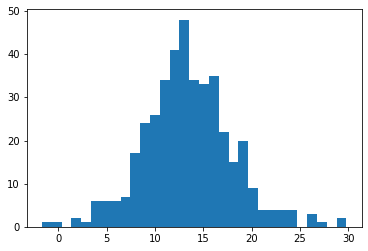

In [45]:
plt.hist(df['PER'], bins=31)

In [46]:
max_per = df[df['PER'] == df['PER'].max()]
print('Player with maximum PER for year {} is {} with PER of {}'.format(year, max_per.index[0], max_per['PER'][0]))


Player with maximum PER for year 2014 is Kevin Durant with PER of 29.8


In [29]:
unique_pos = np.unique(df['Pos'])
print (unique_pos)

['C' 'PF' 'PG' 'SF' 'SG']


First let's look at the distribution of the PER accross all players for yaer 2014

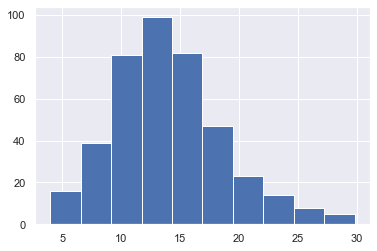

In [266]:
plt.hist(df['PER'])
plt.show()

Now we will split the data to positions to see if there is any diffrence

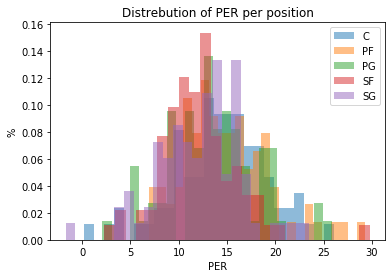

In [42]:
for p in unique_pos:
    plt.hist(df[df['Pos']==p]['PER'], alpha=0.5, label=p, bins=25, density=True)
plt.xlabel('PER')
plt.ylabel('%')
plt.title('Distrebution of PER per position')
plt.legend()
plt.show()
#TODO: 1 figure of 5 PDFs (same colors). 2 Sub-plots

Assuming Normal distrebution - let's find the $\Theta=(\mu , \sigma)$ parameeters for each position

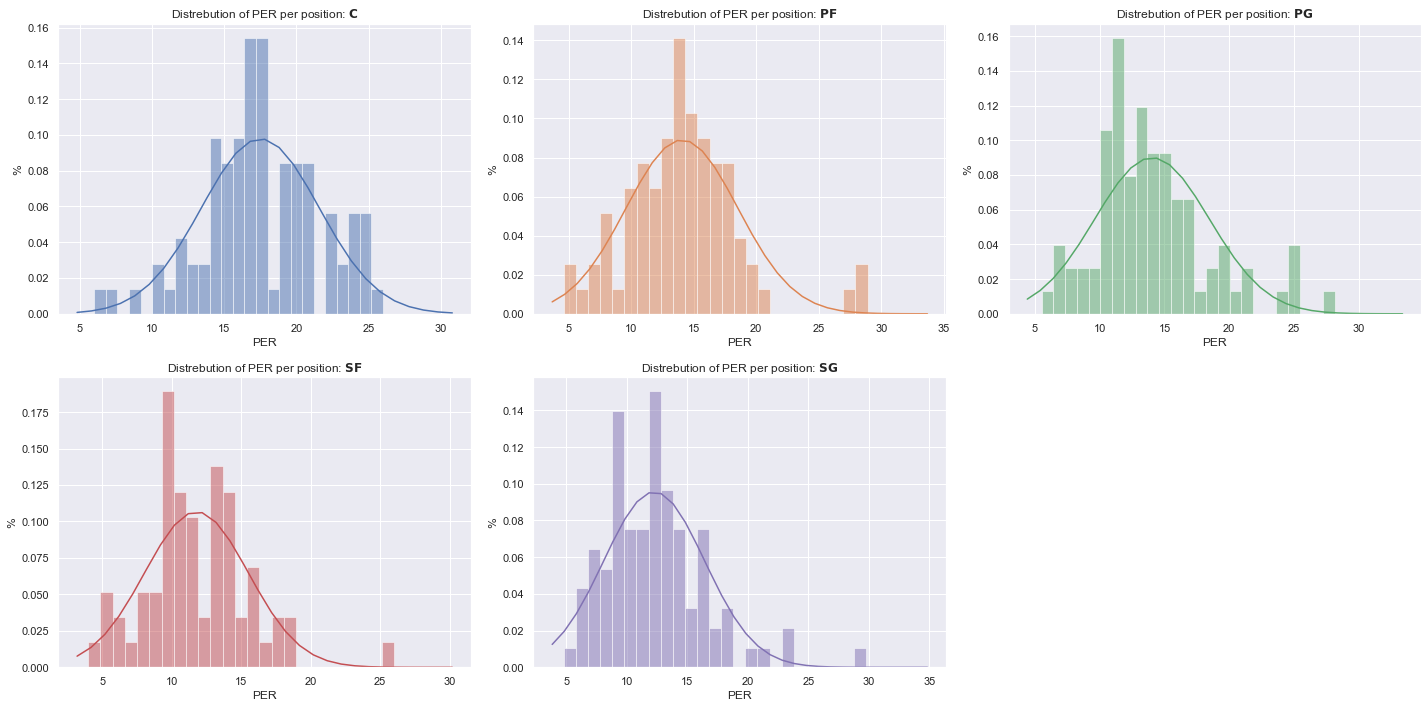

In [180]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
for i,p in enumerate(unique_pos):
    d = df[df['Pos']==p]['PER']
    x_axis = np.arange(np.min(d)*0.8, np.max(d)*1.2, 1)
    axes[i//3][i%3].plot(x_axis, scipy.stats.norm.pdf(x_axis,np.mean(d),np.std(d)), color=current_palette[i])
    axes[i//3][i%3].hist(df[df['Pos']==p]['PER'], alpha=0.5, label=p, bins=25, density=True, color=current_palette[i])
    axes[i//3][i%3].set_xlabel('PER')
    axes[i//3][i%3].set_ylabel('%')
    axes[i//3][i%3].set_title(f'Distrebution of PER per position: ' + r"$\bf{" + p + "}$")
# plt.legend()
axes[-1, -1].axis('off')
fig.tight_layout()
plt.show()


We can see from the plots above that the PER is now distrebuted the same accross all positions!!

OK... So that means that MVP should be the player that was performing best in his position.

We can start with taking the naive approach and see which is the player that is far from the mean value of the performances within the rest of the players in his position

In [254]:
def std_dist(per, mean_per, std_per):
    return (per-mean_per)/std_per

In [270]:
print (f"\033[4mYear: {year}\033[0m")
max_per_pos_dict = {}
for i,p in enumerate(unique_pos):
    pos_df = df[df['Pos']==p]
    max_per = pos_df[pos_df['PER'] == pos_df['PER'].max()]
    std_d = std_dist(max_per['PER'][0], np.mean(pos_df['PER']), np.std(pos_df['PER']))
    print (f'For position {p}:')
    print (f"Player with maximum PER within position is {max_per.index[0]} with PER = {max_per['PER'][0]}")
    print (f'Which is {std_d:.2f} far from mean value')
    max_per_pos_dict[p] = max_per

Year: 2014
For position C:
Player with maximum PER within position is Boban Marjanović with PER = 26.0
Which is 2.09 far from mean value
For position PF:
Player with maximum PER within position is Anthony Davis with PER = 28.9
Which is 3.31 far from mean value
For position PG:
Player with maximum PER within position is Stephen Curry with PER = 28.2
Which is 3.19 far from mean value
For position SF:
Player with maximum PER within position is Kevin Durant with PER = 26.0
Which is 3.80 far from mean value
For position SG:
Player with maximum PER within position is James Harden with PER = 29.8
Which is 4.20 far from mean value


That is just.... Wow!

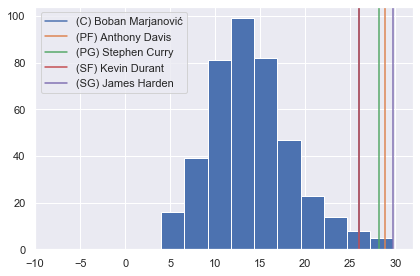

In [286]:
plt.hist(df['PER'])
for i,(k,v) in enumerate(max_per_pos_dict.items()):
    plt.axvline(v['PER'][0], color=current_palette[i], label=f"({k}) {v.index[0]}")
# fig = plt.figure(figsize=(18, 18))
plt.xlim(-10,32)
plt.tight_layout()
plt.legend()
plt.show()

OK. So if we want to extract the best player with regards to his position, we need to be able to find the best efit for the 

In [208]:
years_range=(2006,2019)

In [209]:
columns_to_convert = ['Age','G','MP','PER','TS%','3PAr','FTr','ORB%','DRB%','TRB%','AST%','STL%','BLK%',
                    'TOV%','USG%','OWS' ,'DWS','WS','WS/48','OBPM','DBPM','BPM','VORP']
mean_per = []
for y in range(*years_range,1):
    url = 'https://www.basketball-reference.com/leagues/NBA_{}_advanced.html'.format(y)
    df=fetch_data(url)
    preprocess_df(columns_to_convert)
    mean_per.append(np.mean(df['PER']))

In [210]:
mean_per

[13.16666666666667,
 13.425765306122448,
 13.36921052631579,
 13.517847769028869,
 13.61111111111111,
 13.447814910025706,
 13.692171717171718,
 13.68337531486146,
 13.471219512195123,
 13.867303102625298,
 13.900726392251816,
 13.745762711864407,
 14.024396135265702]

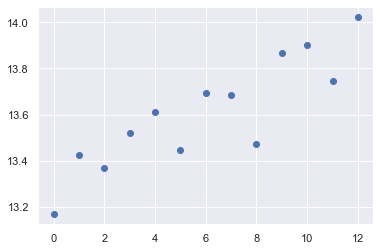

In [211]:
plt.plot(mean_per, 'o')

In [212]:
from scipy.optimize import curve_fit

In [213]:
def lin_func(x,a,b):
    return a*x+b

In [214]:
pars, cov = curve_fit(f=lin_func, xdata=range(*years_range,1), ydata=mean_per)

In [215]:
pars

array([ 5.42668709e-02, -9.55754542e+01])

In [216]:
cov

array([[ 7.97044097e-05, -1.60365272e-01],
       [-1.60365272e-01,  3.22656041e+02]])

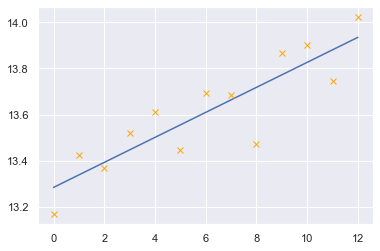

In [217]:
plt.plot(lin_func(range(*years_range,1), pars[0], pars[1]))
plt.plot(mean_per, 'x', color='orange')
plt.show()
#TODO: Add variance to the line. Maybe sample from the normal dist of a,b

In [227]:
a_prior = scipy.stats.norm(5, 0.2)
b_prior = scipy.stats.norm(-9, 0.1)
σ_prior = scipy.stats.expon(0.1)

def log_prior(θ):
    a, b, σ = θ
    return a_prior.logpdf(a) + b_prior.logpdf(b) + σ_prior.logpdf(σ)

def log_likelihood(θ, x, y):
    a, b, σ = θ
    yhat = a * x + b
    return scipy.stats.norm(yhat, σ).logpdf(y).sum()

def log_posterior(θ, x, y):
    logpri = log_prior(θ)
    if np.isinf(logpri): return logpri
    return logpri + log_likelihood(θ, x, y)

In [236]:
ndim = 3
nwalkers = 50
nsteps  = 200
nburn = nsteps // 2
var_names = ['a', 'b', 'σ']

guesses = np.random.rand(nwalkers, ndim)
guesses[:, 0] = a_prior.rvs(nwalkers)
guesses[:, 1] = b_prior.rvs(nwalkers)
guesses[:, 2] = σ_prior.rvs(nwalkers)

In [237]:
x = range(*years_range,1)
y = mean_per

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[x, y])
sampler.run_mcmc(guesses, nsteps);

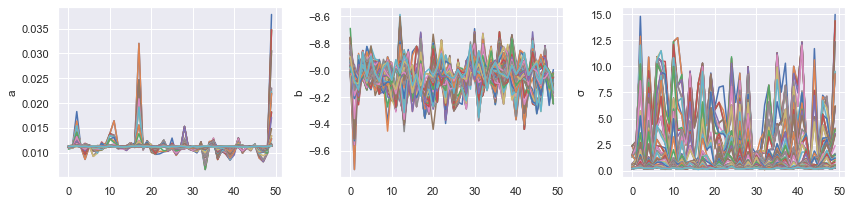

In [238]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3))
for i, param in enumerate(['a', 'b', 'σ']):
    axes[i].plot(sampler.chain[:, nburn:, i])
    axes[i].set_ylabel(param)
fig.tight_layout()

In [239]:
samples = sampler.chain[:, nburn:, :].reshape((-1, ndim))
θ_bayes = samples.mean(axis=0)
# print("Normal: a={:.3f}, b={:.3f}".format(*θ_norm))
print("Bayes:  a={:.3f}, b={:.3f}, σ={:.3f}".format(*θ_bayes))

Bayes:  a=0.011, b=-9.047, σ=1.487


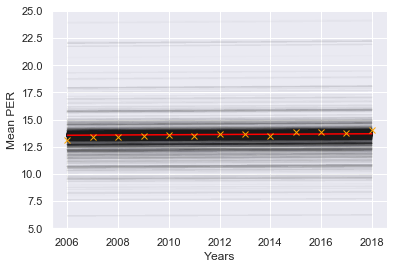

In [244]:
#plt.plot(lin_func(range(*years_range,1), pars[0], pars[1]))

for θi in samples:
    ai, bi, _ = θi
    yhat = ai * x + bi
    plt.plot(x, yhat, '-k', alpha=0.01)
    
a, b, σ = θ_bayes
yhat = a * x + b
plt.plot(x, yhat, color='red')
# comment out the next lines to get a predictive interval around the linear estimate
# plt.plot(x, yhat+σ, color=red)
# plt.plot(x, yhat-σ, color=red)

plt.plot(range(*years_range,1), mean_per, 'x', color='orange')
plt.ylim(5,25)

plt.xlabel('Years')
plt.ylabel('Mean PER')
sns.despine()

In [241]:
#TODO: Try to fit diffrent lines

In [242]:
from corner import corner

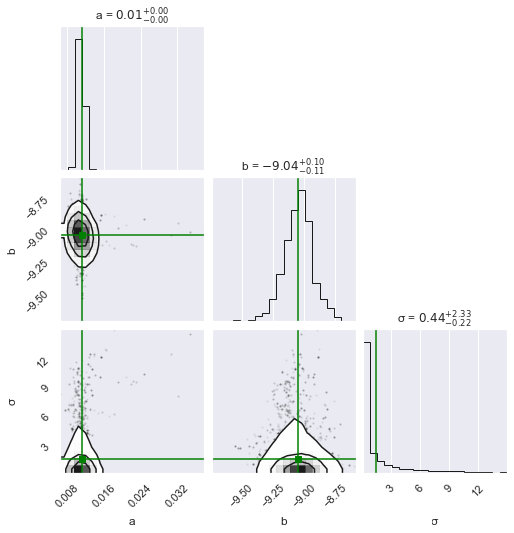

In [243]:
corner(
    samples, 
    smooth=True, 
    labels=var_names, 
    show_titles=True, 
    truths=θ_bayes, 
    truth_color="green"
);

In [207]:
#TODO: MVP per year: take max PER and player.